## Part 3 - Cross correlation and confidence intervals

In this last part we will see how to extract the planet signal after having removed the effects of telluric lines in the spectra. The signal is still at a low level in real data so we need to "amplify" it by using cross correlation with model spectra.

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import simulator_code as sim

Let us reload the data we are going to use and the same model we have injected, so that we can use it to cross correlate the data.

In [2]:
wData = np.load('wlen_regr.npy')      # Data wavelengths
fData = np.load('output/tsub.npy')           # Telluric-removed data
wMod = np.load('wmod.npy')            # Model wavelengths
fMod = np.load('fmod.npy')            # Model fluxes

# Other useful vectors
ph = np.load('ph.npy')                # Orbital phases
rvel = np.load('rvel.npy')            # Systemic + Barycentric RVs

### 3.1 The "forward" approach: a grid of cross correlation values
We will compute the cross correlation as a function of <i>lag</i>, that is radial velocity shift. We are initially using the same lag vector for all the spectra, which we define below. RV lags are spaced by 1.5 km/s in this case, which matches the sampling of the CRIRES detector (2 pixels per resolution element, 1 resolution element = 3 km/s at R=100,000).

In [3]:
ncc = 333                                       # Number of cross correlation values
rvlag = (np.arange(ncc) - (ncc-1)//2) * 1.5     # RV lag centred around zero and with step 1.5 km/s
print(rvlag[0],rvlag[-1])

-249.0 249.0


Now we will explicitly compute the cross correlation between the model and the data for each lag and each of the spectra in the sequence. We will write the entire code below, except for the actual cross-correlation which is in <code>simulator_code.py</code>. 

One detail specific to this code, though, is that normally discrete cross correlation functions are computed as a function of lag vectors of integer pixels. Here instead we move in radial velocity, so each step of 1.5 km/s will correspond to a non-integer amount of pixels on the detector. To solve this problem, we use spline interpolation to shift the model by fractional pixels prior to cross-correlation and then we compute the cross correlation at lag zero.

In [4]:
no, nf, nx = fData.shape        # N.detectors, N.spectra, N.spectral channels
c = 2.998E5                     # Speed of light in km/s

# Defining matrix that will contain CCFs
ccf = np.zeros((no,nf,ncc))

# Looping over detectors
for io in range(no):
    # The second loop must be in RV to spare computational time
    for irv, rv in enumerate(rvlag):
        wMod1 = wMod.copy() * (1.0 + rv/c)          # Doppler-shifted model wavelengths
        # Shifting model spectrum by spline interpolation
        coef_spline = interpolate.splrep(wMod1, fMod, s=0.0)
        intMod = interpolate.splev(wData[io,], coef_spline, der=0)
        # Compute CC between shifted model and data for each spectrum (looping over time)
        for j in range(nf):
            ccf[io,j,irv] = sim.xcorr(fData[io,j,], intMod, nx)

# Saving the CCFs
np.save('output/ccfs.npy', ccf)

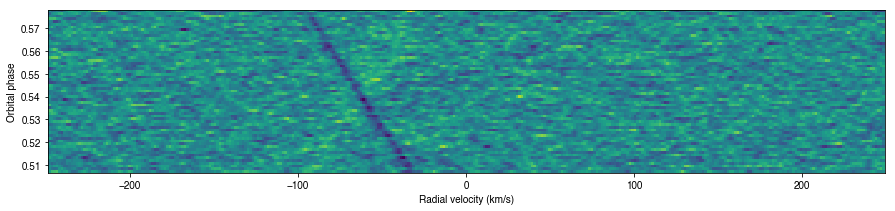

In [5]:
# Summing up the CCF from different detectors and plotting it in reversed color scheme
ccfSum = ccf.sum(axis=0)
lims = [rvlag[0],rvlag[-1],ph[0],ph[-1]]
plt.figure(figsize=(15,3))
plt.imshow(-ccfSum,origin='lower',extent=lims,aspect='auto')
plt.xlabel('Radial velocity (km/s)')
plt.ylabel('Orbital phase')
plt.show()

After computing and co-adding all the cross correlation functions of different detectors (no weighting applied so far), we can already see by eye a definite slanted "trail" that starts at about -30 km/s and ends at about -100 km/s. This is indeed the planet signal, and it changes in radial velocity because the planet moves along the orbit. In particular, in this specific case the planet is post-superior conjunction (post secondary eclipse if transiting) so its radial component is blue-shifted and the absolute value of RV grows with phase going towards quadrature (phase 0.75). So we are indeed seeing the right signal. 

How do we co-add this signal in time (or equivalently phase)? If you knew the planet RV exactly this would just require shifting each CCF to the planet rest frame and then co-adding. However, even for transiting planets, RVs are only known to a few km/s precision, well above the resolution of these observations. Furthermore, only co-adding at the planet RV does not reveal possible systematic noise that mimics the presence of the planet at different RVs. Therefore the common approach is to co-add the planet RV in time based on a grid of orbital parameters. Let's write down the planet RV equation:
$$ RV_P = V_{sys} + V_{bary} + K_p \sin(2\pi\varphi) $$
where $V_{sys}$ is the systemic velocity, $V_{bary}$ is the barycentric velocity of the observer (a combination of the rotational and orbital motion of the Earth projected in the direction of the system, which we assume well known to within m/s), $K_p$ is the maximum amplitude of the planet orbital radial velocity (i.e. the value that it would have at quadrature) and $\varphi$ is the orbital phase. Of the quantities above, $K_p$ is generally the most uncertain, followed by $\varphi$ if the planet is non-transiting and/or it has very old ephemerides. When observing for a few hours only around phase 0 or 0.5, the change in RV with time is approximately constant (i.e. the planet radial velocity is approximately a straight line rather than a sinusoidal). This means that a shift in phase corresponds to a shift in global RV, so errors in $\varphi$ and $V_{sys}$ can be factored in together with a single parameter $V_{rest}$, i.e. the shift from the planet rest-frame velocity. In conclusion, we have got two parameters to explore, that is $V_{rest}$ and $K_p$.

In [6]:
# Defining vectors for co-adding of the CCFs
nKp = 81
nVr = 81
kpVec = np.arange(nKp) - (nKp-1)//2 + 145     # Centred on the injected RV
vrest = (np.arange(nVr) - (nVr-1)//2)*1.5     # Centred on zero rest-frame velocity

# Defining matrix containing the co-added CCFs
ccfTot = np.zeros((nKp,nVr))

# For each pair (Kp, Vrest) compute the co-added CCF. In practice it only requires looping over Kp, 
# because the interpolation will take care of Vrest automatically
for ikp in range(nKp):
    rvPl = rvel + kpVec[ikp] * np.sin(2.0*np.pi*ph)
    for j in range(nf):
        outRV = vrest + rvPl[j]
        fit = interpolate.interp1d(rvlag, ccfSum[j,])
        ccfTot[ikp,] += fit(outRV)

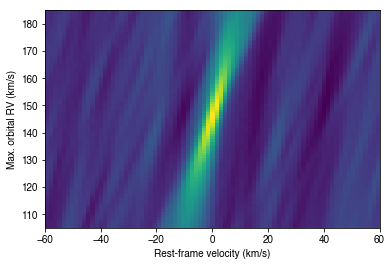

Peak position in Vrest = 0.0 km/s
Peak position in Kp =  146.0 km/s


In [7]:
lims = [vrest[0],vrest[-1],kpVec[0],kpVec[-1]]
plt.imshow(ccfTot,origin='lower',extent=lims,aspect='auto')
plt.xlabel('Rest-frame velocity (km/s)')
plt.ylabel('Max. orbital RV (km/s)')
plt.show()

# Asking the code to locate the peak
ipeak = np.where(ccfTot == ccfTot.max())
bestVr = float(vrest[ipeak[1]])
bestKp = float(kpVec[ipeak[0]])
print('Peak position in Vrest = {:3.1f} km/s'.format(bestVr))
print('Peak position in Kp = {:6.1f} km/s'.format(bestKp))

It looks good! The total CCF peaks at zero rest-frame velocity (expected because we know exactly the systemic valocity and the orbital phase when we inject signals) and at the injected Kp of 145.9 km/s. The question is: how strong is this detection? One way of answering this is to measure the peak CCF value in relation to the surrounding noise. Computing the noise is no easy task, because CCFs tend to have aliases and also couples of (Vrest, Kp) values are correlated. This is clear in the figure, where the peak is not a well defined, circular shape, but rather an oval with tilted axes. We can try to estimate the stdev of CC values away from the peak and use that as noise:

In [8]:
noise = np.std( ccfTot[ np.abs(range(nKp)-ipeak[0]) > 3 , np.abs(range(nVr)-ipeak[1]) > 3 ] )
peak = ccfTot.max()
print('The S/N of the detection is {:4.1f}'.format(peak / noise))

The S/N of the detection is 14.0


But is this reliable? A better statistical test would be to go back to the (RV, phase) CC matrix and ask ourselves if the distribution of the in-trail CC values has a mean significantly different from the distribution of the out-of-trail values. This can be done with a generalised t-test which we coded in <code>simulator_code.py</code>.

To select the two sample, we need to compute how far the fixed RV grid is from the planet RV. We will define a vector of "RV distance" with the same dimensions of <code>ccfSum</code> and use the best-fitting values for (Vrest, Kp):

In [ ]:
rvDist = np.zeros((nf, ncc))
rvPl = rvel + bestKp * np.sin(2.*np.pi*ph) + bestVr
for j in range(nf):
    rvDist[j,] = np.abs(rvlag-rvPl[j])
    
inTrail = ccfSum[rvDist < 1.5]
outTrail = ccfSum[rvDist > 10.0]

p2t, sigma = sim.do_ttest(inTrail, outTrail)
print('t-test on the CC values retrieves a signal at {:4.1f} sigma'.format(np.abs(sigma)))

t-test on the CC values retrieves a signal at 14.9 sigma


This might look like an excellent agreement, however we have manually chosen the width of the in-trail distribution to be 1.5 km/s, i.e. the FWHM of CRIRES instrument profile. This is supported by prior knowledge of the instrument, and it can be quickly checked that increasing the width of the in-trail distribution leads to rapidly decreasing signal. Also, it is good to quote detections, but not quite to quote confidence intervals.

### 3.2 MCMC on high-res data

We want to eliminate the necessity to explore a grid in Kp and Vrest, with associated interpolation of CCFs, and be able to assess confidence intervals. Naturally, this leads to the application of MonteCarlo techniques on the data. Running MCMCs requires mapping the CC values into a log-likelihood function. In Brogi & Line (2019) we have described a general mapping valid under all conditions, but for this quick demonstration we will only explore velocities and we have high-SNR data, hence we can use the mapping of Zucker (2003) which is:
$$ \log(L) = -\frac{N}{2} \log(1 - CC^2), $$
where $N$ is the number of spectral channels and $CC$ is the cross-correlation value.

The code for the MCMC is based on the <code>emcee</code> Python module and it is not shown here, however you can find it in <code>simulator_code.py</code>.

In [ ]:
# True values of Kp and Vrest
kp0 = 145.9
vr0 = 0.0

# Running the MCMC
sim.run_mcmc(kp0, vr0, wMod, fMod, wData, fData, rvel, ph)

[####                          ]